# Learning in ANNs: Gradient Descent, Backpropagation, Automatic Differentiation

In this session, we will discuss how to train Multi-Layer Perceptrons (MLPs). The principles conveyed in this session are applicable not only to neural networks of different kinds but to any differentiable function. We will start from a historic perspective on ANNs and the difficulty of setting their weights and then discuss gradient descent and more generally reverse mode automatic differentiation. We will then go on to implement an ANN from scratch, derive local derivatives of involved computations and chain them to backpropagate gradients through the network.

While this session is mathematically more involved, for practical purposes, getting the general idea will suffice. You will likely not need to do the math to compute gradients for your ANNs yourself. Knowing how they are computed however is very important to understand more involved phenomena and problems in optimization.

### Historical background: The learning rule of a single perceptron (layer)

A single perceptron (or a layer of perceptrons for multivariate targets) can be trained with a simple learning rule, the **Delta rule** that Frank Rosenblatt came up with already in 1958:
$$\Delta w_k^i = \eta (y^i- {\hat{y}}^i) x_k$$

where $\eta$ is a **learning rate**.

Since a single layer of perceptrons can only discriminate between linearly separable feature vectors, there is a need to use multiple perceptron layers stacked on top of each other, using a sequence of (linear transformation, non-linearity). This limitation of perceptrons, and the lack of efficient weight update schemes for multi-layer perceptrons (and Rosenblatt's death before he could write a reply to criticism from symbolic AI proponent Marvin Minsky) effectively led to a first winter in ANN research. But now how do we update the weights in an MLP?

To know how to update a weight, we need to know its contribution to the output of the MLP. How to do this efficiently was eventually figured out when David Rumelhart and Geoffrey Hinton came up with the idea of **error backpropagation** in 1985 while working on a research program they called _"Parallel Distributed Processing"_. A less known fact is that they were not the only ones who came up with this idea: Paul Werbos had already come up with the same scheme in his PhD thesis in 1974.

The idea of backpropagation is to compute the gradients of the loss with respect to the weights. In the single layer case this could be done by the delta rule, so what the backpropagation represents is a **generalization of the delta rule** to the case where we have multiple layers of perceptrons.

Later on, the idea of backpropagation was further generalized to yield algorithms for **automatic differentiation** on any function for which we know the derivatives of the individual local computations involved.

Before diving into the idea of automatic differentiation, the aim of which is to have an efficient way of computing the gradients of the loss function with respect to the weights, we need to understand what _gradients of the loss function_ actually means and why finding these gradients would be useful for optimizing neural networks.

The idea of gradient descent is that we can find minima of a function by following the opposite of its **gradient**. The gradient of a function of a vector of weights $\vec{w}$ can be written as $\nabla_{\vec{w}} f(\vec{w})$ and it is a vector of the partial derivatives of $f$ with respect to each element $w_i$ in $\vec{w}$:

$$\nabla_{\vec{w}} f(\vec{w}) = \begin{pmatrix} \frac{\partial f}{\partial w_0} \\\frac{\partial f}{\partial w_1} \\... \\ \frac{\partial f}{\partial w_n}\end{pmatrix}$$

This gradient points in the **locally steepest direction of function value increase**. If we want to minimize an error function, the idea is to follow the opposite direction of this gradient. By iteratively following and re-computing the gradient in **small steps**, we can end up reducing the error function. Given that $f$ is convex (meaning there exist no local minima that are not identical to the global minimum) and we take small enough steps, convergence to the global minimum is guaranteed.

So we are interested in finding the partial derivatives of a loss/error function with respect to the weights. From calculus we know a bunch of rules that govern differentiation. Of particular interest to us is the **chain rule of calculus**: 

If we have a composite function $f(x) = g(h(x))$, then the chain rule can be expressed in shorthand notation as $$f'(x) = g'(h(x)) h'(x)$$

Now with an MLP we do have such a composite function in the sense that one layer computes an output which then is the input to the next layer. In fact with two layers, we could define one layer as $g$ and the other layer as $h$ and yet another function $\mathcal{L}$ as the error or **loss** function. Finding the gradients $\nabla_w \mathcal{L(w)}$ can be decomposed into finding partial derivatives of the loss function with respect to the parameters in layers $g$ and $h$.

The idea is that we can first compute the partial derivatives of the outermost functions/layers and then, to obtain the derivatives of the earlier layers, we can multiply the local derivatives of their output with what we already computed for the outer functions. We have  $f = \mathcal{L}(g(w_1, h(w_0, x)))$ and we want $f_{w_1}'$. We need to first differentiate through the loss function.

For the mean squared error $\mathcal{L}_{\text{MSE}} = \frac{1}{2} (\hat{y}_w - y)^2$ this equals $\hat{y}_w - y$. To then obtain the gradients w.r.t the weights $w_1$ of the outermost layer $g$, we multiply $\hat{y}_w - y$ with $g'_w(x)$. The same logic applies to the weights of layer $h$. Once we have the partial derivatives w.r.t. the next layer's weights, we can compute the derivatives w.r.t. the previous layer's weights etc.. It is for this logic of computing gradients and then iteratively passing them down from the output of the ANN all the way to the input of the ANN (applying the chain rule) that it was called backpropagation.

As it turns out, to compute the gradients in this fashion, it is highly useful to keep track of intermediate results during the **forward pass** (calling the MLP on an input), as they are needed to compute the local derivatives. The general logic of training MLPs thus is to first compute a prediction with a model and keep intermediate outputs in memory before using these values in the backward pass.

## Automatic Differentiation

While the original backpropagation learning rule was special to computations occuring in multi-layer perceptrons, a more modern approach is to have a library that tracks the **computational graph** and for each basic operation knows the derivative. During the backward pass the computational graph is reversely followed, making use of our knowledge of the derivatives of the individual small computations. With an automatic differentiation framework such as Tensorflow we can compute gradients (and thus perform gradient descent based optimization) on arbitrary functions that do not even have to be considered neural networks.

Now that we've covered the general idea of how to update the weights of a neural network by incrementally following the negative of the gradient of the loss with respect to the model parameters, let's get our hands dirty by deriving some math and then applying the math to optimize a neural network that predicts real world housing prices. 

# Training a neural network on the boston housing data

The boston housing data is a real data set of 404 examples of houses and their prices. We want to use the 13 features to predict the price of a house. 

We create a neural network (multi-layer perceptron) that takes input data and transforms it, using linear transformations (matrix multiplication) and non-linear activation functions (sigmoid), to compute predictions of house price.

We will use 3 layers. The first layer has 20 hidden units, the second layer has 10 hidden units and the third layer, which is the output layer, has 1 unit (just like the target). We use TensorFlow instead of numpy but really we use it in pretty much the same way as numpy. TensorFlow more conveniently allows to compute multiple matrix, matrix multiplications simultaneously compared to numpy, and it can run the code on a GPU and compile it for greater speed.

The weight matrices have shape (13,20), (20,10) and (10,1), following the convention (n_in, n_out).

We start by loading the training and validation data and defining a batch size. The batch size tells us how many examples we use to compute the gradients. The input data should have the shape (batch_size, n_features) and the labels should have the shape (batch_size, n_targets), where in this case n_targets is 1 because the house price that we predict is a scalar.

# Ethics of predictive modeling

When dealing with and learning about technical details of powerful tools such as machine learning, it is easy to forget about the real world and societal impact of these tools. Before attempting any project that involves real world data involving humans in machine learning or deep learning, there are some very important ethical questions that you should reflect on to evaluate the potential impact of your model/application. While models at initialization do usually not include any racial or other unwanted biases, the data usually reflects these biases. You may think that if the data does not contain a variable called "race", there is no risk of the model effectively using it to make decisions. This is unfortunately not true. There are almost always features that are caused and thereby correlated with features that we do not want to use to discriminate against people directly or indirectly (e.g. race, gender, ideology, political belief etc.)

The particular dataset that we use here has been shown to have an ethical problem: the authors included a variable, "B", that may appear to assume that racial self-segregation influences house prices. The data set should thus not be used for any use case or analysis, unless in the context of illustrating ethical issues in data science and machine learning.

In [366]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

batch_size=32
train_data, val_data = tf.keras.datasets.boston_housing.load_data()

print(f"Number of labeled examples: {train_data[0].shape[0]}")
print(f"Number of features used to predict house price: {train_data[0].shape[1]}")
print(f"Number of features to predict: 1 \n")
print(f"batch size is {batch_size}")

all_inputs = tf.constant(train_data[0], dtype=tf.float32)
all_inputs = tf.reshape(all_inputs, (all_inputs.shape[0], all_inputs.shape[1]))

val_all_inputs = tf.constant(val_data[0], dtype=tf.float32)
val_all_inputs = tf.reshape(val_all_inputs, (val_all_inputs.shape[0], val_all_inputs.shape[1]))

# normalize input data with training data statistics
all_inputs = all_inputs / tf.reduce_max(all_inputs, axis=-2, keepdims=True)
val_inputs = val_all_inputs / tf.reduce_max(all_inputs, axis=-2, keepdims=True)

all_targets = tf.constant(train_data[1], dtype=tf.float32)
all_targets = tf.expand_dims(all_targets, axis=-1)

val_all_targets = tf.constant(val_data[1], dtype=tf.float32)
val_all_targets = tf.expand_dims(val_all_targets, axis=-1)

# look at first example batch
inputs = all_inputs[:batch_size]
target = all_targets[:batch_size]

print(f"inputs have shape {inputs.shape}")
print(f"targets have shape {target.shape}\n")

print(f"Example data: {inputs[0]}\n")
print(f"Example label: {target[0]}")

Number of labeled examples: 404
Number of features used to predict house price: 13
Number of features to predict: 1 

batch size is 32
inputs have shape (32, 13)
targets have shape (32, 1)

Example data: [0.01385168 0.         0.2934391  0.         0.61768085 0.70395416
 0.917      0.37131545 0.16666667 0.4317862  0.95454544 1.
 0.49302077]

Example label: [15.2]


### The forward computation of an ANN

Next we define the computations in which these weights are used.

We have 3 layers and we want to apply a sigmoid activation function after every layer.

We also compute the error between the output and the target values using a **Mean Squared Error**.

In [367]:
weights_1 = tf.random.uniform(shape=(13,20))
weights_2 = tf.random.uniform(shape=(20,10))
weights_3 = tf.random.uniform(shape=(10,1))

# layer 1
f7_o = inputs @ weights_1
# activation function of layer 1
f6_o = tf.nn.sigmoid(f7_o)

# layer 2
f5_o = f6_o @ weights_2
# activation function of layer 2
f4_o = tf.nn.sigmoid(f5_o)

# layer 3 (output layer)
f3_o = f4_o @ weights_3
# activation function of layer 3 (output layer)
f2_o = tf.nn.sigmoid(f3_o)

# error function, here MSE
f1_o = tf.reduce_mean(0.5 * (f2_o - target)**2, axis=None) # mean squared error

print(f"predictions are {f2_o.numpy().squeeze()} \n while the targets are {target.numpy().squeeze()}")
print(f"\n This makes a mean squared error of {f1_o}")

predictions are [0.99328536 0.99328405 0.993286   0.99328405 0.9932863  0.99328476
 0.9932864  0.9932858  0.99328506 0.99328595 0.9932864  0.9932859
 0.9932844  0.9932863  0.99328554 0.9932862  0.99328655 0.9932841
 0.99328434 0.99328506 0.9932858  0.9932841  0.9932846  0.9932838
 0.9932845  0.99328643 0.9932847  0.99328405 0.9932852  0.993285
 0.99328476 0.9932864 ] 
 while the targets are [15.2 42.3 50.  21.1 17.7 18.5 11.3 15.6 15.6 14.4 12.1 17.9 23.1 19.9
 15.7  8.8 50.  22.5 24.1 27.5 10.9 30.8 32.9 24.  18.5 13.3 22.9 34.7
 16.6 17.5 22.3 16.1]

 This makes a mean squared error of 272.683837890625


Our model can be described as a composite function of 7 computations, most of which are already composite functions (e.g. sigmoid activation function or the MSE-loss):

$$\mathcal{L} = f_1(f_2(f_3( f_4(f_5(f_6(f_7(x,w_1)), w_2  )  ) ) , w_3)   , \text{target})$$

What we want to find is the tuple of partial derivatives, that is the gradient, of $f_1$ w.r.t. the parameters ($w_1, w_2, w_3$).

#### Using the chain rule

Because this is a composite function we can apply the **chain rule** of calculus, according to which the derivative is computed as the outer derivative given the unchanged output of the inner function, multiplied by the derivative of the inner function, again keeping its input unchanged, if $x$ in the formula below turns out to be another function:

$$\frac{d}{{dx}}\left[ {f_1\left( f_2 \right)} \right] = \frac{d}{{df_2}}\left[ {f_1\left( f_2 \right)} \right]\frac{{df_2}}{{dx}}$$


### Local derivatives

All we need to compute the partial derivatives of the loss function w.r.t. the network parameters (here only the weights, since we do not use a bias) is the derivatives of the individual or composite computations involved.

Our composite function (the joint forward pass and loss computation of an ANN) makes use of three kinds of composite computations:
- Mean squared error (MSE)
- Sigmoid activation function
- Matrix multiplication

### Local derivatives of MSE

$\mathcal{L}_{\text{MSE}} = f_1(\text{f2_o}) = \frac{1}{2} (\text{f2_o} - \text{t})^2$

The derivative of this w.r.t. the ANN's final layer's output *f2_o* is

$\frac{\partial \mathcal{L}}{\partial \text{f2_o}} = \text{f2_o} - \text{t}$

### Local derivatives of the sigmoid activation function

Activation functions are typically denoted as $\sigma(x)$. Here, the sigmoid activation function is defined by:

$\sigma(x) = \frac{1}{1+\text{e}^{-x}}$

and its derivative turns out to be

$\frac{\partial \sigma}{\partial \text{x}} = \sigma(x) ( 1 - \sigma(x))$

Since an activation function is an element-wise operation, we also chain this local derivative $\sigma'(x)$ with $\frac{\partial \mathcal{L}}{\partial \sigma(x)}$ by element-wise multiplication.

### Local derivatives of matrix multiplication

A matrix multiplication is a linear operation that takes two arguments, so we can differentiate w.r.t. either the first matrix or the second matrix - in neural networks this is either the input to the layer or the weights of that layer.

Let's say we have the following matrix multiplication

$C = A B$

and we already have the gradients of the loss function w.r.t. the output of this matrix multiplication C, that is we have $\frac{\partial \mathcal{L}}{\partial C}$.

The partial derivative of the loss $\mathcal{L}$ w.r.t. $A$ turns out to be

$\frac{\partial \mathcal{L}}{\partial A} = \frac{\partial \mathcal{L}}{\partial C} B^{\text{T}}$.

Likewise the partial derivative w.r.t. matrix $B$ turns out to be

$\frac{\partial \mathcal{L}}{\partial B} = A^{\text{T}} \frac{\partial \mathcal{L}}{\partial C}$.

**For a handwritten explanation, please refer to the additional material provided in the same folder as this notebook.**


This is it, we know all the local derivatives involved in the computation of the loss that we want to minimize by changing the weights in the three layers. 

Let's have another look at the forward computation of the loss, in which we store intermediate computations and below refer to them in the math notation of the backpropagation by their variable names, hopefully making it easier to relate the math to the code:

In [368]:
# layer 1
f7_o = tf.matmul(inputs, weights_1)
# activation function of layer 1
f6_o = tf.nn.sigmoid(f7_o)

# layer 2
f5_o = tf.matmul(f6_o, weights_2)
# activation function of layer 2
f4_o = tf.nn.sigmoid(f5_o)

# layer 3 (output layer)
f3_o = tf.matmul(f4_o, weights_3)
# activation function of layer 3 (output layer)
f2_o = tf.nn.sigmoid(f3_o)

# error function, here MSE
f1_o = tf.reduce_mean(0.5 * (f2_o - target)**2,axis=None) # mean squared error

### Backpropagation

We start with the partial derivative of the mean squared error w.r.t. the network output f2_o:
$$\frac{\partial \mathcal{L}}{\partial f_2} = \text{f2_o} - \text{t}$$

Next we want to differentiate through the sigmoid activation function. We take an element-wise product between the outer derivative and the inner derivative $\sigma'(x)$, the definition of which you can find in the *local derivatives* section.

$$\frac{\partial \mathcal{L}}{\partial f_3} = \frac{\partial \mathcal{L}}{\partial f_2} \circ \sigma'(\text{f3_o})$$

We can already compute the gradients w.r.t. the weights of the last layer. We use the result we got above in the *local derivatives* section to know how to do this.

$$\frac{\partial \mathcal{L}}{\partial \text{W}_3} = \text{f4_o}^{\text{T}} \frac{\partial \mathcal{L}}{\partial f_3}$$

Now we want to differentiate with respect to the last layer's input, f4_o - again using the logic from the *local derivatives* section.

$$\frac{\partial \mathcal{L}}{\partial f_4} = \frac{\partial \mathcal{L}}{\partial f_3} {\text{W}_3}^{\text{T}}$$

The next step to differentiate through backwards is again a sigmoid activation function. We can thus follow the same procedure as we did before:

$$\frac{\partial \mathcal{L}}{\partial f_5} = \frac{\partial \mathcal{L}}{\partial f_4} \circ \sigma'(\text{f5_o})$$

Now we want to differentiate through the matrix multiplication of layer 2, first w.r.t. the layer's input:

$$\frac{\partial \mathcal{L}}{\partial f_6} = \frac{\partial \mathcal{L}}{\partial f_5} {\text{W}_3}^{\text{T}}$$

We can now get the gradients of the weights of layer 2, by differentiating the same matmul operation from the forward computation w.r.t. the weights, following the same logic as before for the gradients of weights_3:

$$\frac{\partial \mathcal{L}}{\partial \text{W}_2} = \text{f6_o}^{\text{T}} \frac{\partial \mathcal{L}}{\partial f_6}$$

This is becoming quite repetitive - given that we have the gradients of the loss function w.r.t. the second layer's inputs, we can differentiate through the activation function of layer 1:

$$\frac{\partial \mathcal{L}}{\partial f_7} = \frac{\partial \mathcal{L}}{\partial f_6} \circ \sigma'(\text{f7_o})$$

Sometimes we are interested in the gradients of the loss w.r.t. the input data. We can obtain these by differentiating through the matrix multiplication of the first layer w.r.t. the inputs:

$$\frac{\partial \mathcal{L}}{\partial \text{inputs}} = \frac{\partial \mathcal{L}}{\partial f_7}  {\text{W}_1}^{\text{T}}$$

Finally, and lastly, we compute the gradients of the loss $\mathcal{L}$ w.r.t. the first layer's weights:

$$\frac{\partial \mathcal{L}}{\partial \text{W}_1} = \text{f7_o}^{\text{T}} \frac{\partial \mathcal{L}}{\partial f_7}$$


Now that we have derived the computations for chaining the local derivatives such that we compute the gradients of the mean-squared-error loss w.r.t. the weights, we can compute the gradients using TensorFlow (again, numpy would also work).

In [369]:
# Gradients of MSE (d L/ d f2)
grad_f1_o = (f2_o - target)

# Chain gradients of MSE with gradients of output activation function
# (d L / d f3)
grad_f2_o = grad_f1_o *(tf.nn.sigmoid(f3_o)*(1-tf.nn.sigmoid(f3_o)))

# compute gradients w.r.t the last layer's weights (weights_3)
# (d L / d weights_3)
grad_w3 = (tf.transpose(f4_o) @ grad_f2_o) / batch_size

# chain with derivative of matrix multiplication of layer 3
# d L / d f4
grad_f3_o = grad_f2_o @ tf.transpose(weights_3)

# chain with derivative of activation function (layer 3)
# d L / d f5
grad_f4_o = grad_f3_o * (tf.nn.sigmoid(f5_o)*(1-tf.nn.sigmoid(f5_o)))

# chain with derivative of matrix multiplication of layer 2
# d L / d f6
grad_f5_o = grad_f4_o @ tf.transpose(weights_2)

# compute gradients w.r.t. layer 2's weight matrix
# d L / d weights_2
grad_w2 = (tf.transpose(f6_o) @ grad_f4_o) / batch_size

# chain with layer 2's sigmoid activation function
# d L / d f7
grad_f6_o = grad_f5_o * (tf.nn.sigmoid(f7_o)*(1-tf.nn.sigmoid(f7_o)))

# compute gradients w.r.t. the input
# d L / d inputs
grad_inputs = grad_f6_o @ tf.transpose(weights_1)

# compute gradients w.r.t. layer 1's weights
# d L / d weights_1
grad_w1 = (tf.transpose(inputs) @ grad_f6_o) / batch_size

Let's check whether our implementation that we got by chaining local derivatives of atomic computations involved actually gives us the correct gradients w.r.t. to the network weights.

To do this, we rely on Tensorflow's **reverse mode automatic differentiation**, which does exactly what we just did, relying on optimized computational graph structures to reduce the number of operations. In the next session (03) you will learn how to use this tool.

In [370]:
with tf.GradientTape() as tape:
    tape.watch([weights_1, weights_2, weights_3])
    f7_o = tf.matmul(inputs, weights_1)
    f6_o = tf.nn.sigmoid(f7_o)
    f5_o = tf.matmul(f6_o, weights_2)
    f4_o = tf.nn.sigmoid(f5_o)
    f3_o = tf.matmul(f4_o, weights_3)
    f2_o = tf.nn.sigmoid(f3_o)

    f1_o = tf.reduce_mean(0.5 * (f2_o - target)**2) # mean squared error
    
real_grad_w1, real_grad_w2, real_grad_w3 = tape.gradient(f1_o, [weights_1,
                                                                weights_2,
                                                                weights_3])

In [386]:
tolerance = 0.0
print(f"gradients for weights_1 match tensorflow oracle: \
    {np.allclose(grad_w1, real_grad_w1, atol=tolerance)}")
print(f"gradients for weights_2 match tensorflow oracle: \
    {np.allclose(grad_w2, real_grad_w2, atol=tolerance)}")
print(f"gradients for weights_3 match tensorflow oracle: \
    {np.allclose(grad_w3, real_grad_w3, atol=tolerance)}")

gradients for weights_1 match tensorflow oracle:     True
gradients for weights_2 match tensorflow oracle:     True
gradients for weights_3 match tensorflow oracle:     True


Now that we have some confidence that both our math and our implementation are correct, we can use this to train the ANN on the boston housing data! For that we need to define the training logic.

The procedure is as follows, we define a **learning rate** and a **batch size**, and then we iterate over batches of examples from the data set. Once we've processed every element in the training data, we're done with one **epoch** and we repeat the next process until we have trained for a desired number of epochs.

Below there are some differences to the above network:

- we initialize the weights differently (more on this in a later session)

- we include a bias in our network (the local derivative of the bias is just 1)

- we remove the sigmoid on the output, because it is a regression task

To train the network weights, we need four functions:
- the **forward computation** (including the loss function), that also returns the intermediate results
- the **backward (gradient) computation** that takes the results from forward computation and backpropagates the gradients to the network parameters, returning a tuple of parameter gradients.
- the **weight update**, in which we pair the gradients with their respective parameter array/tensor and subtract a fraction of the gradients from the parameters
- the **training loop** which applies the three functions for a number of iterations, computing the loss (and intermediate activations and pre-activations), backpropagating the error (computing gradients), and applying the gradients to update the weights and the biases of the network.

In [428]:
def initialize_weights(n_inputs, n_units_1, n_units_2, n_units_3):

    # He-Uniform initialization for better learning
    limit_1 = np.sqrt(6 / n_inputs)
    limit_2 = np.sqrt(6 / n_units_1)
    limit_3 = np.sqrt(6 / n_units_2)

    weights_1 = tf.random.uniform(minval=-limit_1, maxval=limit_1, shape=(n_inputs,n_units_1))
    weights_2 = tf.random.uniform(minval=-limit_2, maxval=limit_2, shape=(n_units_1,n_units_2))
    weights_3 = tf.random.uniform(minval=-limit_3, maxval=limit_3, shape=(n_units_2,n_units_3))

    # this time using a bias in our model
    bias_1 = tf.Variable(tf.zeros(n_units_1))
    bias_2 = tf.Variable(tf.zeros(n_units_2))
    bias_3 = tf.Variable(tf.zeros(n_units_3))

    weights_1 = tf.Variable(weights_1)
    weights_2 = tf.Variable(weights_2)
    weights_3 = tf.Variable(weights_3)

    weights = ((weights_1,bias_1), 
               (weights_2,bias_2), 
               (weights_3, bias_3))
    
    return weights

In [429]:
@tf.function(jit_compile=True) # for speed
def compute_forward_pass(inputs, target, weights):
    
    weights_1 = weights[0][0]
    weights_2 = weights[1][0]
    weights_3 = weights[2][0]
    bias_1    = weights[0][1]
    bias_2    = weights[1][1]
    bias_3    = weights[2][1]
    
    # layer 1, now with bias
    f7_o = tf.matmul(inputs, weights_1) + bias_1
    # activation function of layer 1
    f6_o = tf.nn.sigmoid(f7_o)
    
    # layer 2, now with bias
    f5_o = tf.matmul(f6_o, weights_2) + bias_2
    # activation function of layer 2
    f4_o = tf.nn.sigmoid(f5_o)

    # layer 3 (output layer), now with bias
    f3_o = tf.matmul(f4_o, weights_3) + bias_3
    # activation function of layer 3 (output layer)
    # skip the last layer's sigmoid f2_o = tf.nn.sigmoid(f3_o) 

    # error function, here MSE
    f1_o = tf.reduce_mean(0.5 * (f3_o - target)**2) # mean squared error

    return (f1_o, f3_o, f4_o, f5_o, f6_o, f7_o, inputs)

In [430]:
@tf.function(jit_compile=True) # for speed
def compute_gradients(weights, data_from_forward, target, batch_size):
    
    # unpack weights and data from the forward-step
    ((weights_1,bias_1), 
     (weights_2, bias_2), 
     (weights_3,bias_3)) = weights
    (f1_o, f3_o, f4_o, f5_o, f6_o, f7_o, inputs) = data_from_forward
    
    # Gradients of MSE (d L/ d f2)
    grad_f1_o = (f3_o - target)

    # chain with derivative of matrix multiplication of layer 3
    # d L / d f4
    grad_f3_o = grad_f1_o @ tf.transpose(weights_3)
    
    # compute gradients w.r.t the last layer's weights (weights_3)
    # (d L / d weights_3)
    grad_w3 = (tf.transpose(f4_o) @ grad_f1_o) / batch_size
    
    # (d L / d bias_3)
    grad_b3 = tf.reduce_sum(grad_f1_o,axis=0) / batch_size

    # chain with derivative of activation function (layer 3)
    # d L / d f5
    grad_f4_o = grad_f3_o * (tf.nn.sigmoid(f5_o)*(1-tf.nn.sigmoid(f5_o)))

    # chain with derivative of matrix multiplication of layer 2
    # d L / d f6
    grad_f5_o = grad_f4_o @ tf.transpose(weights_2)

    # compute gradients w.r.t. layer 2's weight matrix
    # d L / d weights_2
    grad_w2 = (tf.transpose(f6_o) @ grad_f4_o) / batch_size
    
    # (d L / d bias_2)
    grad_b2 = tf.reduce_sum(grad_f4_o,axis=0) / batch_size

    # chain with layer 2's sigmoid activation function
    # d L / d f7
    grad_f6_o = grad_f5_o * (tf.nn.sigmoid(f7_o)*(1-tf.nn.sigmoid(f7_o)))

    # compute gradients w.r.t. the input
    # d L / d inputs
    grad_inputs = grad_f6_o @ tf.transpose(weights_1)

    # compute gradients w.r.t. layer 1's weights
    # d L / d weights_1
    grad_w1 = (tf.transpose(inputs) @ grad_f6_o) / batch_size
    
    # (d L / d bias_1)
    grad_b1 = tf.reduce_sum(grad_f6_o,axis=0) / batch_size

    return ((grad_w1, grad_b1), 
            (grad_w2, grad_b2), 
            (grad_w3, grad_b3))

In [431]:
def update_weights(weights, weight_gradients, learning_rate=1e-2):
    for params, grads in zip(weights, weight_gradients):
        for p, p_grad in zip(params, grads):
            p = p.assign(p - learning_rate*p_grad)
    return weights

In [455]:
def minimize_loss(weights, batch_size, 
                  learning_rate, epochs=2, 
                  training_data=None, 
                  val_data=None):
    
    all_inputs, all_targets = training_data
    val_all_inputs, val_all_targets = val_data if val_data else (None,None)
    epoch_wise_losses = []
    val_epoch_wise_losses = []
    
    # iterate over epochs
    for e in range(epochs):
        losses = []
        
        # iterate over batches in the data set
        for i in range(all_inputs.shape[0]//batch_size):
            
            # subset the training data for the current batch
            inputs = all_inputs[i*batch_size:i*batch_size+batch_size]
            targets = all_targets[i*batch_size:i*batch_size+batch_size]
            
            # do the forward pass
            data_from_forward = compute_forward_pass(inputs, 
                                                     targets, 
                                                     weights)
            # log the loss
            losses.append(data_from_forward[0].numpy())
            
            # compute gradients
            grads = compute_gradients(weights, data_from_forward, 
                                      targets, 
                                      batch_size=batch_size)
            # update the weights
            weights = update_weights(weights, grads, learning_rate=learning_rate)
            
        # report loss at end of epoch
        print(f"epoch:{e} loss={np.mean(losses)}")
        # log loss for epoch
        epoch_wise_losses.append(np.mean(losses))
        
        if val_data:
            val_data_from_forward = compute_forward_pass(val_all_inputs, 
                                                     val_all_targets, 
                                                     weights)
            val_epoch_wise_losses.append(val_data_from_forward[0].numpy())
            print(f"epoch:{e} val_loss={val_epoch_wise_losses[-1]}\n")
    return epoch_wise_losses, val_epoch_wise_losses

In [484]:
n_inputs = 13
n_units_1 = 16
n_units_2 = 8
n_units_3 = 1

# instantiate weights
weights = initialize_weights(n_inputs, n_units_1, n_units_2, n_units_3)

training_losses, val_losses = minimize_loss(weights=weights,
                      batch_size=8, epochs=25,
                      learning_rate=4e-3, training_data=(all_inputs, all_targets),
                                           val_data = (val_all_inputs, val_all_targets))

print(f"\n For previously unseen houses, the model's predictions are off by {np.sqrt(val_losses[-1])} on average")

epoch:0 loss=153.89581298828125
epoch:0 val_loss=75.04292297363281

epoch:1 loss=50.2238883972168
epoch:1 val_loss=46.17360305786133

epoch:2 loss=43.004207611083984
epoch:2 val_loss=43.477569580078125

epoch:3 loss=42.73936462402344
epoch:3 val_loss=42.92287063598633

epoch:4 loss=42.66010665893555
epoch:4 val_loss=42.71744155883789

epoch:5 loss=42.5479850769043
epoch:5 val_loss=42.51738357543945

epoch:6 loss=42.401912689208984
epoch:6 val_loss=42.4486083984375

epoch:7 loss=42.204463958740234
epoch:7 val_loss=41.99867248535156

epoch:8 loss=41.91493606567383
epoch:8 val_loss=41.37021255493164

epoch:9 loss=41.45710754394531
epoch:9 val_loss=40.72182846069336

epoch:10 loss=40.747459411621094
epoch:10 val_loss=39.94678497314453

epoch:11 loss=39.82044982910156
epoch:11 val_loss=39.28278350830078

epoch:12 loss=38.78224182128906
epoch:12 val_loss=37.677764892578125

epoch:13 loss=37.651248931884766
epoch:13 val_loss=36.88502883911133

epoch:14 loss=36.409461975097656
epoch:14 val_los

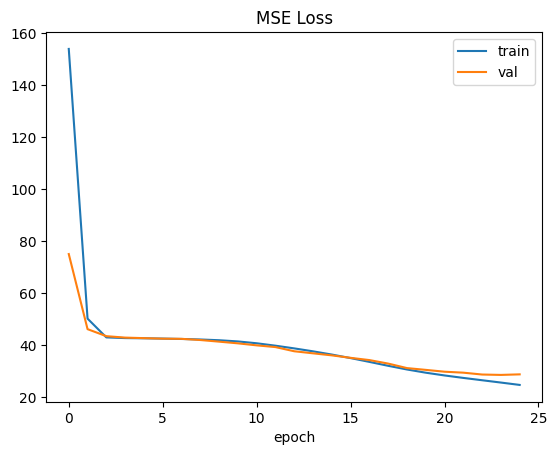

In [485]:
plt.plot(training_losses, label="train")
plt.plot(val_losses,label="val")
plt.title("MSE Loss")
plt.xlabel("epoch")
plt.legend()
plt.show()

We have just built our first artificial neural network almost completely from scratch! First we derived the computation of gradients mathematically by using the chain rule and subsequently implemented this in TensorFlow, which allowed us to easily perform highly optimized batched matrix multiplications. We evaluated our solution against TensorFlow's automatic differentiation and found that the computed gradients match to the last floating point. Lastly we implemented a complete training logic to train the network architecture on the ethically questionable Boston Housing data set, a real world data set with 404 examples of houses, described by 13 features, to predict their prices.


## Some (important) notes

You may encounter some unanswered questions when trying to find gradients for more complicated composite functions. One possibility is that the same weight matrix (or activation tensor) affects the loss through multiple paths. In this case we need to aggregate the gradients obtained through these paths by summation. The same applies for a case in which we have a batch of inputs and not a single (input, output) example. In this case, you also aggregate the gradients obtained for each example by averaging, as we've done above. Deep Learning frameworks do batched matrix multiplications in a highly optimized way by utilizing the capabilities for parallelism of modern graphic processing units (GPUs) or other accelerators.


## Conclusion

We have found the computations needed to obtain the gradients of our composite function w.r.t. some variables (here weights and biases). Let's note some important observations that we may have made along the way:

- Ethical considerations on whether data implicitly contains historically grounded racial or other biases are important and should come first, not as an afterthought. The data set we used here for illustration does contain such biases and should not be taken for any serious analysis or modeling.


- Doing it by hand is tedious and the mathematical expressions for the gradients get very long, even for a shallow neural network of just 3 layers.


- We really only need to know the local derivatives of the basic computations involved in a composite function (such as any kind of ANN) to compute gradients of the complete function.


- The intermediate computations that arise in the function's forward pass are re-used in the backward computation of its gradients.


- The same logic can be applied for any kind of directed acyclic graph composed of smaller functions that are differentiable. As such, it can be used to compute gradients for any neural network architecture (CNNs, RNNs, etc.), as long as the individual network components have known local derivatives.


- In automatic differentiation frameworks, functions are constructed on graphs that contain inputs, parameters, as well as the operations, their local derivatives and the intermediate results to be re-used in the backward pass. There is no need to chain derivatives together manually in these frameworks as we did here!